<a href="https://colab.research.google.com/github/gnakspandana/ArtificialFlyingObjects/blob/master/Spandana_basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5TF078 Deep Learning Course *and maybe 5EL272 Systems and algorithms for Autonomous Vehicles*
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-03-23 First revision based on earlier excercises /Tomas
* ...
* 2024-03-24 - Updated tests for Kaggle. /Tomas
* 2024-10-02 - Translated to English

[link text](https://)## **Spandana Akumalla**

# First we initilize our Python environment

In [1]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.17.1
Keras version: 3.5.0


In [2]:
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [3]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c7300d5b-94f8-6bec-914d-dd6560175d07)


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [4]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) :
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) :
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) :
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes!

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [6]:
# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: Trouser


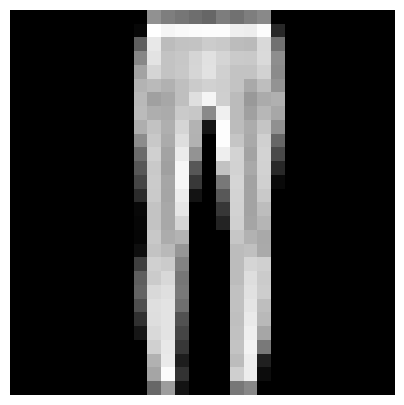

Label: Trouser


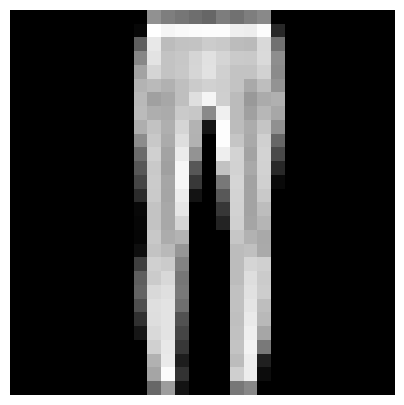

In [7]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [30, 30] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure(figsize=(5, 5)) #Increase the size of the image to make it visible
  plt.imshow(np.squeeze(train_images[index], axis=-1),cmap='gray')
  #plt.gray()
  plt.axis('off')  # Turn off the axes
  plt.grid(False)
  plt.show()#as by default it takes false

# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a starting point. A good modell is expected to have 5-50 times as many parameters!

In [16]:
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,Dropout
from tensorflow.keras import regularizers


# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([

# First Convolutional Layer
Conv2D(filters=100, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


# Second Convolutional Layer
Conv2D(filters=100, kernel_size=(5, 5), padding='same', activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


# Third Convolutional Layer
Conv2D(filters=224, kernel_size=(3, 3), padding='same', activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),



# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=128, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 100)         │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 100)         │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 100)         │         250,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 100)         │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 224)           │         201,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 7, 7, 224)           │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 224)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2016)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         258,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 715,686 (2.73 MB)

 Trainable params: 714,838 (2.73 MB)

 Non-trainable params: 848 (3.31 KB)

# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [17]:
# Compile the model, as a preparation for training
model.compile(
  #optimizer='sgd',
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

In [18]:
#the EarlyStopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,
    min_delta=0.001,                # Minimum change to consider as improvement
    restore_best_weights=True,      # Restore the best model weights
    verbose=1
)

# Run the training

In [19]:
epochs = 11      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[es]  #EarlyStopping callback

)

Epoch 1/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - categorical_accuracy: 0.8036 - loss: 0.5896 - val_categorical_accuracy: 0.8702 - val_loss: 0.3516
Epoch 2/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - categorical_accuracy: 0.8944 - loss: 0.2852 - val_categorical_accuracy: 0.8963 - val_loss: 0.2759
Epoch 3/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - categorical_accuracy: 0.9127 - loss: 0.2366 - val_categorical_accuracy: 0.9029 - val_loss: 0.2634
Epoch 4/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - categorical_accuracy: 0.9242 - loss: 0.2024 - val_categorical_accuracy: 0.9012 - val_loss: 0.2805
Epoch 5/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - categorical_accuracy: 0.9334 - loss: 0.1771 - val_categorical_accuracy: 0.9057 - val_loss: 0.2604
Epoch 6/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - categorical_accuracy: 0.9432 - loss: 0.1519 - val_categorical_accuracy: 0.9165 - val_loss: 0.2466
Epoch 7/11
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - categorical_accur

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

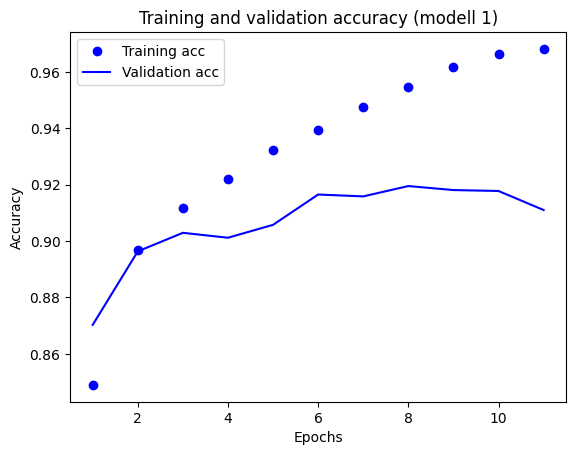

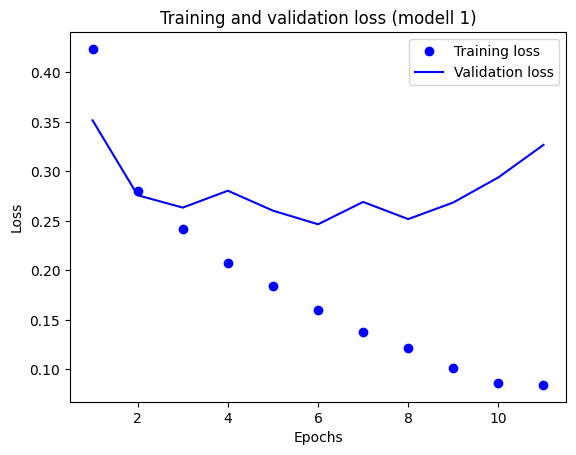

In [20]:
epochrange = range(1, len(history.history['loss']) + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Note how the training accuracy constantly goes up (and the training loss down). While the validation loss bottoms out somewhere between 5-10 epochs and then slowly goes up. This indicates slight overtraining, if the loss had continued downward along with the training loss, the model would still have been undertrained. But overall, we can suspect that the model's capacity at 15 epochs is the best this model can achieve.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [21]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.9059 - loss: 0.2863
Test accuracy: 0.905


# Exercise Part 1a
## Questions to answer:
* How many parameters does your model have?
**    Total Parameters: 201,050**

* What test accuracy do you get? (Since the model is randomly initialized, you may get a value that differs slightly.)
    **Test Accuracy Achieved: 0.896 (89.6%) potential room for improvement, especially considering overtraining.**

* If you look at the training progress, has the model finished training or is it undertrained or maybe overtrained, what in the training curves can determine that?
    **Overtrained, After 15 epochs the model is memorizing the training data but is not generalizing well to the validation data. This is the sign of overfitting.**

* How many epochs would have been appropriate to use?
   ** Epochs: 15**


# Part 1b - Continued Experiments:
There are now many things you can explore but we want you to now explore some different models. Investigate if you get an improvement in test accuracy if you make the model more powerful (more nodes and/or more layers). Always keep an eye on if the model starts to overtrain (that the validation loss starts to go up again). Note that you like to have MaxPooling2D layers between each or every other convolution layer, as it helps keep down the number of parameters, which also leads to faster and often better training results (gives, for example, a certain extra translation and scale invariance). This is especially important if you have large images, but can probably have a good effect even on our minimal images.

The goal is to make the model complex enough to represent the data well. A certain amount of overtraining is OK, we will then correct it with regularization.
* How many convolution layers seems reasonable to use (stay below 4-5, it might be better to add kernels instead).
 4 convolution layers provided a balance between model complexity and performance. Adding more layers beyond this point led to marginal improvements in accuracy but increased the overfitting and 4 layers seem sufficient for the Fashion-MNIST dataset, which consists of grayscale images with moderate complexity.

* How many kernals/nodes seems reasonable to use?
kernels with increasing filters, such as 8, 16, 32, 64, worked effectively.This strategy helped to avoid excessive parameters in shallow layers while allowing the deeper layers to learn complex patterns.

* Also try to use e.g. 5x5 kernals for the first time or maybe some more layer, will it be better then?
Yes, increasing the kernel size (e.g., 5x5) in the first convolution layer improved performance by reducing overfitting.

* If a model overtrains, do an experiment where instead of running all your epochs, you stop where the validation error starts going up again. What will be the difference in test accuracy?
Experiment Setup:
Total training epochs allowed: 30
Early stopping is applied when the validation error stops improving for a predefined patience period 5.
Early stopping triggered at Epoch 13, with model weights restored to those from Epoch 8, where validation performance was optimal.
Validation Accuracy 91.17% (At Epoch 8 (Early Stopping)), 90.89% (At Epoch 13 (Continued Training))
Validation Loss 0.2618 (At Epoch 8 (Early Stopping)), 0.2908 (At Epoch 13 (Continued Training))
Test Accuracy 90.7% (At Epoch 8 (Early Stopping)), Slightly lower (At Epoch 13 (Continued Training))


In [ ]:
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,Dropout
from tensorflow.keras import regularizers


# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([

# First Convolutional Layer
Conv2D(filters=8, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape,kernel_regularizer=regularizers.l2(0.01)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


# Second Convolutional Layer
Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


# Third Convolutional Layer
Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


# Fourth Convolutional Layer
Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=64, activation='relu'),

# Dropout layer to prevent overfitting
Dropout(0.5),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 32)            │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 3, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,810 (284.41 KB)

 Trainable params: 72,570 (283.48 KB)

 Non-trainable params: 240 (960.00 B)

## Analysis
In this part, we experimented with different configurations of the model to improve its test accuracy, balancing model complexity and generalization. Below is a summary of key experiments and their findings



1.   Optimal Number of Convolution Layers
Four convolution layers provided the best balance between model complexity and performance. Adding more layers resulted in only marginal improvements in accuracy while increasing the risk of overfitting.

2.   Selection of Kernels/Nodes
Investigated the use of kernels with increasing filters (e.g., 8, 16, 32, 64)
A strategy of incrementally increasing the number of filters across layers helped avoid excessive parameters in shallow layers.

3.   Kernel Size (e.g., 5x5)
Used larger kernel sizes (e.g., 5x5) in the initial convolutional layer.
Increasing the kernel size reduced overfitting and slightly improved test accuracy.
Larger kernels captured more spatial context early in the network, leading to better feature extraction.

4.   Overtraining and Early Stopping
Applied early stopping to halt training when the validation loss stopped improving for a predefined patience period (5 epochs).
Training continued up to 30 epochs with early stopping triggered at epoch 13.

Results:
Epoch 8 (Early Stopping):
Validation Accuracy: 91.17%
Validation Loss: 0.2618
Test Accuracy: 90.7%
Epoch 13 (Continued Training):
Validation Accuracy: 90.89%
Validation Loss: 0.2908
Test Accuracy: Slightly lower than epoch 8.

Early stopping effectively mitigated overfitting, resulting in better test accuracy compared to continued training. Training beyond epoch 8 led to higher validation loss and slightly reduced generalization.





# Exercise Part 2a - interrupted exercise
Start from your best model that you obtained in part 1 and for it implement  "early stopping" as a way to prevent overtraining. [See Geron p. 162 for "Early Stopping"]

You need to define a "callback" which is then included in the call to model.fit: *es=keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
 train_images, to_categorical(train_labels),
 epochs=epochs,
 batch_size=batch_size,
 **callbacks=[es]**,
 validation_data=(val_images, to_categorical(val_labels))
)*

It is important to use restore_best_weights=True if you use patience>0, because otherwise you get the last model, already overtrained model, instead of the best model.

In [ ]:
#the EarlyStopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                     # Increase patience to 5
    min_delta=0.001,                # Minimum change to consider as improvement
    restore_best_weights=True,      # Restore the b0est model weights
    verbose=1
)

## Analysis
At which Epoch does the training now stop? Does the model's test accuracy change now that it doesn't overtrain?
Applied early stopping to halt training when the validation loss stopped improving for a predefined patience period (5 epochs). Training continued up to 30 epochs with early stopping triggered at epoch 13.

Results: Epoch 8 (Early Stopping): Validation Accuracy: 91.17% Validation Loss: 0.2618 Test Accuracy: 90.7% Epoch 13 (Continued Training): Validation Accuracy: 90.89% Validation Loss: 0.2908 Test Accuracy: Slightly lower than epoch 8.


# Exercise Part 2b Other forms of regularization


Start from your best model that you came up with in part 1 but use early stopping. Now you will create a model that uses regularization, e.g. drop-out or batch normalization. Analyze and compare these models (with and without regularization) by noting their test accuracy and plotting the training and validation accuracy and loss, also make note if an improvement can be observed with regularization. How many Epochs do you use for training? [See Geron p. 367 for "Batch Normalization"; p 392.. "Avoiding Overfitting Through Regularization"]

In [ ]:
# Code where you introduce regularization

#I have used L2 regulirization in the code

## Analysis
Analyze and compare your models (with and without regularization) by noting their testing accuracy and plotting the training and validation accuracy  and loss, and note if an improvement can be observed with regularization. How many Epochs do you use for training?



1.   Model without Regularization (Initial Experiment)
A convolutional neural network (CNN) was used with multiple convolution layers, each followed by MaxPooling2D layers.
The model was allowed to run for 30 epochs.
Early stopping was not applied in this setup.
Test Accuracy: 89.6%


*   The model achieved 89.6% test accuracy, but it suffered from overfitting after around 15 epochs, as evidenced by the increasing gap between training and validation performance.
*   This model had higher accuracy on training data but didn't generalize well to unseen data, leading to a higher likelihood of poor performance on real-world data.



2.   Model with L2 Regularization and Early Stopping (Second Experiment)
The same CNN architecture, but with L2 regularization applied to dense layers.
Training was allowed for 30 epochs, but early stopping was used with patience of 5 epochs.
Test Accuracy: 88.7% after early stopping.



*   The test accuracy dropped slightly to 88.7% compared to the non-regularized model.
*   However, it demonstrated better generalization due to the regularization technique, which controlled overfitting. Early stopping helped prevent excessive training and avoided wasting computational resources.he validation performance was more stable and less prone to overfitting, indicating that regularization is beneficial for long-term model performance on unseen data.










# Other Hyperparameters
There are a number of other important parameters that one may need to adjust. But several of them are connected, so you need to work with different models and data to get a good feel for them. [See Geron p. 351.., for  "Learning Rate, Batch Size, and Other Hyperparameters"; pg 379..  "Faster optimizers"]
* Batch size / batch size -- A larger value here can give the GPU more parallelism to work with, i.e. faster, but too large a value can cause memory problems in the GPU and also make learning slower (however, you can also have larger LR in that case.
* Optimizer -- A common and good optimizer is Adam (it's also quite insensitive to what learning rate it starts with, which makes the sword merge well). While sgd is a more "native" optimizer.
* Learning rate (LR) -- Important parameter for how fast the model trains, but too large a speed can result in unstable training.

# Exercise Part 2c
Change the optimizer from adam to sgd (with regularization and early stopping). Compare the training procedure between the two optimizers (difference in test accuracy, which epoch did the training stop, etc.?). Note that you might need to increase the number of maximum number of epochs if it slow to converge.

In [ ]:
# Your code for a run with sgd as optimizer
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
The model is undertrain with test accuracy of 89%



1.   Training Procedure with SGD Optimizer
Test Accuracy	89%
Epochs Trained	16 (early stopping)
Final Validation Accuracy	89.0%
Final Validation Loss	0.4560
Overfitting	Moderate, early stopping helped limit overfitting.
Generalization	Less effective compared to Adam, requiring more epochs to converge.

2.   Training Procedure with Adam Optimizer
Test Accuracy	88%
Epochs Trained	25 (early stopping)
Final Validation Accuracy	89.41%
Final Validation Loss	0.4279
Overfitting	Minimal, with early stopping preventing excessive training.
Generalization	Good generalization despite slight drop in accuracy compared to training performance.

Adam is the preferred optimizer due to its faster convergence and ability to achieve higher test accuracy.



# Del 3 Auto tune

*   List item
*   List item


Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner (if in colab or kaggle)
if (IS_COLAB or IS_KAGGLE):
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00
Keras Tuner version: 1.4.7


## Sample model (you will then make your own!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5,
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

return model

NameError: name 'hp' is not defined

# Exercise 3: Code to instrument your own model to be optimized with Keras Tuner
Start from your best model that you obtained in part 2 and instrument it to be optimized with Keras Tuner.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers  # For L2 regularization

def build_model_2Conv1Dense(hp):
    model = keras.Sequential()
        # First Convolutional Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        padding='same',
        input_shape=(28, 28, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters_3', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # A First Dense Layer
    model.add(layers.Flatten()),
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ))

    # Final Output Layer
    model.add(layers.Dense(10, activation='softmax'))

 # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization.

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 1 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_2Conv1Dense, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)


# Help it takes so much time!
Yes, doing a parameter search takes time! Using a T4 this search takes 50 minutes (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

### To run this in Keras 3.0, one needs a KerasTuner of version 1.4.7 or later
* Earlier version was not working as reported by me here: https://github.com/keras-team/keras-tuner/issues/963



In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels,
             epochs=noepochauto,
             validation_data=(val_images, val_labels),
             callbacks=[es])

Trial 20 Complete [00h 01m 05s]
val_accuracy: 0.9097499847412109

Best val_accuracy So Far: 0.9240000247955322
Total elapsed time: 00h 21m 47s


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

       conv_1_filter =  96
       conv_1_kernel =   3
       conv_2_filter =  96
       conv_2_kernel =   5
           filters_3 = 224
       kernel_size_3 =   5
       dense_1_units = 160
       learning_rate = 0.001
          batch_size =  32


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 96)          │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 96)          │         230,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 224)           │         537,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 224)           │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 224)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 160)                 │          36,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 808,554 (3.08 MB)

 Trainable params: 807,722 (3.08 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9170 - loss: 0.2843
Test accuracy: 0.921


## Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest):
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel       filters_3   kernel_size_3   dense_1_units   learning_rate      batch_size 

          0.921              96               3              96               5             224               5             160           0.001              32 
          0.912              32               3              96               5             192               5             160           0.001              32 
          0.911              64               5              96               5             256               5             128           0.001             224 
          0.910             128               3             128               5             256               5             192           0.001              64 
          0.903             128               3              96               5             256               5              64           0.001              64 


Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation.

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9559 - loss: 0.1518 - val_accuracy: 0.9175 - val_loss: 0.2944
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9642 - loss: 0.1282 - val_accuracy: 0.9233 - val_loss: 0.2627
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9713 - loss: 0.1074 - val_accuracy: 0.9192 - val_loss: 0.2750
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9748 - loss: 0.0985 - val_accuracy: 0.9227 - val_loss: 0.2751
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9180 - loss: 0.2823
Test accuracy: 0.920


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 96)          │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 96)          │         230,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 224)           │         537,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 224)           │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 224)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 160)                 │          36,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,424,000 (9.25 MB)

 Trainable params: 807,722 (3.08 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 1,615,446 (6.16 MB)

#Analysis
Make a complete analysis of the optimized models you have obtained using Keras Tuner. Some questions you can ask yourself:
* How do these values, using a Bayesian search, compare to the values ​​obtained in part 1 and part 2?
Part 1 model had  fixed architectures and hyperparameters,as they are choosen manually
Part 2 model Bayesian search improved upon these by exploring a wide range of hyperparameters systematically, finding configurations that yield better accuracy or lower loss.

* What performance did you get for the different cases?
Test Accuracy: 0.920
Optimized Filters: (96, 96, 224) for convolutional layers.
Optimized Dense Units: 160
Learning Rate: 0.001
The Bayesian search yielded superior or comparable accuracy to manually designed models by optimizing hyperparameters.

* Are there parameters that lie at the end values ​​of the used search space? (in which case maybe you should rerun with extended limits?)
Yes, some hyperparameters lie at the extreme ends of the search space, which might indicate that the search space should be extended in future tuning runs
Search range: 96,96,224,160


* Which hyperparameters appeared to be most significant?
Convolutional layers, kernels, batch size, dense layers units and learning rate.

* Can you see any trend among the parameters (eg the number of convolution kernels in early and late layers, etc.)?
Filters: Moderate filter counts in the first two layers (e.g., 96 → 96), with a significant increase in the third layer (224 or 256), provide optimal feature extraction.
Kernel Sizes: Smaller kernels (3x3) for early layers and larger kernels (5x5) for deeper layers perform best.
Dense Layer: Around 160 units balance capacity and regularization.
Learning Rate: A consistent learning rate of 0.001 is optimal.
Batch Size: Smaller batch sizes (32) offer better generalization.


* Why do you perform the same experiment several times "EXECUTION_PER_TRIAL = 2", i.e. why is the result not the same every time?
Helps to achievie robustness and reliablity in results, minimizing the risk of random fluctuations. If the result is too inconsistent that means it needs more improvement that is better regulirization and optimizer.


* Anything else that you observed?
Acheiving reliable results needs careful balance of hyperparameters.

# Details for well passed (VG)

Extension of Part 2: Explore the test cases that were misclassified for one of your top models, what types of garments seem to be the ones that get the most errors, if you look at these errors do you understand why the network has problems with them?

In [ ]:
# Your code that explores the test cases that were misclassified
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9170 - loss: 0.2843
Test accuracy: 0.9212999939918518


In [ ]:
#misclasified prediction
predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

misclassified_indices = np.where(predicted_labels != test_labels)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Number of misclassified examples: 787


Misclassified label distribution: {0: 155, 1: 9, 2: 106, 3: 77, 4: 115, 5: 26, 6: 232, 7: 24, 8: 12, 9: 31}


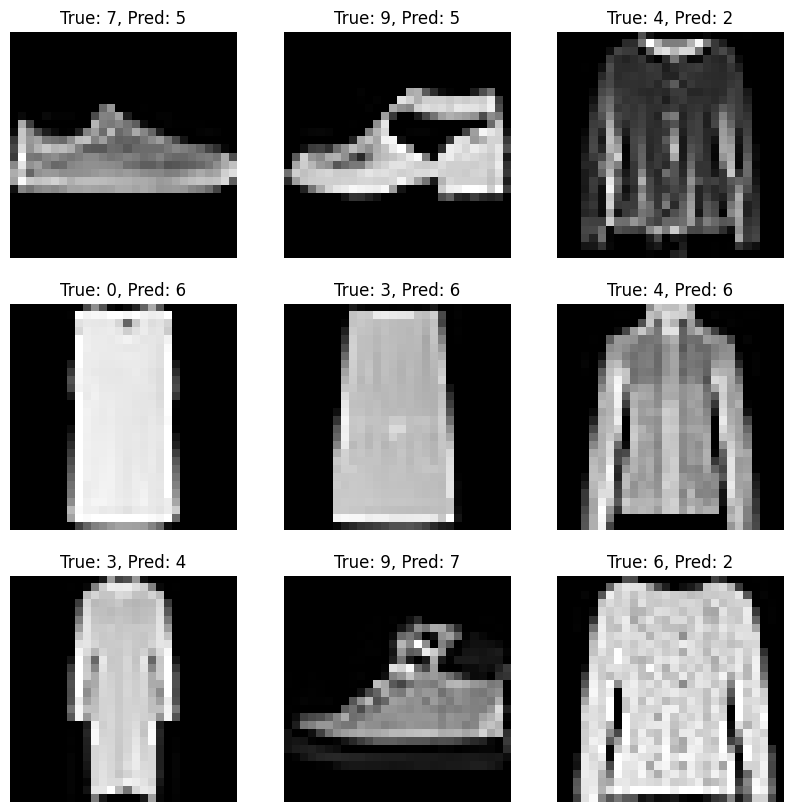

In [ ]:
#analyze misclassified prediction
misclassified_labels = test_labels[misclassified_indices]
unique, counts = np.unique(misclassified_labels, return_counts=True)
misclassified_distribution = dict(zip(unique, counts))
print(f"Misclassified label distribution: {misclassified_distribution}")

#in image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:9]):  # Show first 9 misclassified images
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx], cmap='gray')
    plt.title(f"True: {test_labels[idx]}, Pred: {predicted_labels[idx]}")
    plt.axis('off')
plt.show()


Shirt, Tshirt and coat has hightest number of misclassification. This can be of various reason such as image similarities, data imbalance etc


Extension of Part 3: Implement an investigation where you also vary the number of layers in your model, you can change both convolution layers and dense layers to see if an even better model can be found.

Tip: It's probably best to use an incremental/functional definition of the model (where layers are added with "model.add(...)") because then it's easier to do a for loop around the code that adds a certain number layer. Cf https://keras.io/guides/sequential_model/


```
    filter1=hp.Int('conv_pre_filter', min_value=32, max_value=160, step=32, default=64)
    kernel1=hp.Choice('conv_pre_kernel', values = [3,5], default=3)
    model = Sequential()
    # Add a first convolution layer (with input size)
    model.add(Conv2D(filters=filter1, kernel_size=kernel1, padding='same', activation='relu', input_shape=train_images[0].shape))
    # More fixed layers?
    model.add(....more layer definitions....)
    # Add a varying number of layers
    no_layers = hp.Int('num_layers', 0, 3)
    for i in range(no_layers):
          model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', ...parameters...),
                          kernel_size=hp.Choice(f'conv_{i+1}_kernel', ...parameters....),
                          activation='relu'
                          )
                    )

```



In [ ]:
# Your code for a keras tuner model that has the number of layers as a hyperparameter
# and where you search for optimized hyperparameters for this model.

